In [1]:
%matplotlib inline  
# Load the libraries
import rosbag
import pickle
import glob2, re
import pandas as pd
import numpy as np
import json
import gc
import networkx as nx
import community as comm
from joblib import Parallel, delayed 
from collections import Counter
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap

No handlers could be found for logger "rosout"


# Color palette

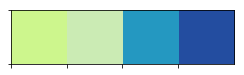

In [44]:
color_map = sns.color_palette("YlGnBu", n_colors=len(ROBOT_RANGE))
color_map = color_map.as_hex()
color_map[0] = '#cdf68d'
color_map[1] = '#cbebb4'


#color_map = sns.cubehelix_palette(n_colors=len(ROBOT_RANGE), light=0.7, rot=-0.4)

linestyles = ['-', '--', '-.', ':', '-']
markers=['x', ',', '^', 'o', '.']
loosely_dotted = (0, (5,10))
#linestyles = ['solid','dashed','dashdot','dotted',loosely_dotted]
linestyles = ['solid','dashed', loosely_dotted]
sns.palplot(color_map)

# Data filtering and conversion

In [3]:
def TopicFilter(bag, BASE_ROBOT_ID):

    topics = bag.get_type_and_topic_info().topics.keys()
    topics_excluing_list = []
    topics_valid_list = []

    # remove topics that appeared in argos
    regex = re.compile('^/epuck+_.+_.+/')
    argos_sim_topics = filter(regex.search, topics)
        
    # count the number of robots present in the rosbag file
    regex = re.compile('^/epuck+_.+/init_merkle_tree')
    number_of_robots_in_bag = len(filter(regex.search, topics))
    
    for id in xrange(BASE_ROBOT_ID,BASE_ROBOT_ID + number_of_robots_in_bag):
        topic_goal = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/goal"
        topic_goal_achieved = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/goal_achieved"
        topic_distance_to_goal = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/distance_to_goal"
        topic_goto = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/go_to"
        topic_results = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/result"
        topic_cancel = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/cancel"
        topic_status = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/status"
        topic_cmd_vel = "/epuck_" + str(id) + "/cmd_vel"

        topics_excluing_list.extend([topic_goal, topic_distance_to_goal, topic_goto, 
                                     topic_goal_achieved, topic_results, topic_cancel, 
                                     topic_status, topic_cmd_vel])

    topics_excluing_list.extend(['/rosout', '/rosout_agg'])
    topics_excluing_list.extend(argos_sim_topics)

    for topic in topics:
        if topic not in topics_excluing_list:
            topics_valid_list.append(topic)
          
    return topics_valid_list

In [4]:
def ROSBagToPandasDataFrame(rosbag_filename, convert_to_csv=False, convert_to_pickle=False, convert_to_msgpack=False, convert_to_hdf5=False):

    bag = rosbag.Bag(rosbag_filename)
    topics_valid_list = TopicFilter(bag, 20)
    msgs = []

    # load the messages into the list
    for topic, msg, t in bag.read_messages(topics=topics_valid_list):
        msgs.append({'topic': topic, 'msg': msg, 't': t})
    
    # close bag
    bag.close()
    
    # robsag to pandas
    df = pd.DataFrame(msgs)
    
    # convert timestamp to pandas datatime format
    timestamps_converted = [str(i)[:13] for i in df['t']]
    df['t'] = pd.to_datetime(timestamps_converted, unit='ms')
    df=df.set_index('t')
    
    if (convert_to_csv):
        df.to_csv(rosbag_filename +'.csv')
    
    if (convert_to_pickle):
        df.to_pickle(rosbag_filename +'.pkl')
        
    if (convert_to_msgpack):
        # Write msgpack file
        with open(rosbag_filename +'.msgpack', "wb") as outfile:
            packed = msgpack.packb(df.to_msgpack())
            outfile.write(packed)
            
    if (convert_to_hdf5):
        df.to_hdf(rosbag_filename +'.hdf5', key='df', mode='w')
            
    # return dataframe
    return df

#  Finishing Time and Success Rate Functions

In [5]:
def MerkleTreeCompletionTimePerRobot(df, robot_topic):
    msgs_topic = df.loc[df['topic'] == robot_topic]['msg']
    msg_begin = msgs_topic.iloc[0]
    msg_end = None
    
    for msg in msgs_topic:
        if(msg.leafs[-1].completed == True):
            msg_end = msg
            break
     
    return msg_end.header.stamp.secs - msg_begin.header.stamp.secs, df.loc[df['msg'] == msg_end].index[0]

In [6]:
def FinishingTimeLastRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, THRESHOLD, DF):
    robots_finishing_list = []

    for id in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        topic_name = '/epuck_' + str(id) + '/comm/merkle_completed'
        try:
            robot_finishing_time = MerkleTreeCompletionTimePerRobot(DF, topic_name)
            if (robot_finishing_time < THRESHOLD):
                robots_finishing_list.append(robot_finishing_time)
        except:
            pass
           
    return max(robots_finishing_list)

In [7]:
def FinishingTimeFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, THRESHOLD, DF):
    robots_finishing_list = []
    robots_finishing_timestamps = []

    for id in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        topic_name = '/epuck_' + str(id) + '/comm/merkle_completed'
        try:
            robot_finishing_time, robot_finishing_timestamp = MerkleTreeCompletionTimePerRobot(DF, topic_name)
            if (robot_finishing_time < THRESHOLD):
                robots_finishing_list.append(robot_finishing_time)
                robots_finishing_timestamps.append(robot_finishing_timestamp)
        except:
            pass
           
    return min(i for i in robots_finishing_list if i > 0), min(robots_finishing_timestamps)

In [8]:
def CompletionSuccess(THRESHOLD, FINISHING_TIMES):
    filtered_times = []

    for t in range(0,THRESHOLD):
        filtered_times.append(len([i for i in FINISHING_TIMES if i <= t]))
  
    return np.true_divide(np.array(filtered_times), len(FINISHING_TIMES))

# Communication Cost and Privacy Functions

In [9]:
# function to get unique values 
def unique(list1): 
    x = np.array(list1)
    return np.unique(x)

In [10]:
def sdi(data):
    from math import log as ln
    
    def p(n, N):
        if n is  0:
            return 0
        else:
            return (float(n)/N) * ln(float(n)/N)
            
    N = sum(data)
    return -sum(p(n, N) for n in data if n is not 0)

In [11]:
# get_size function
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [12]:
def ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, DF):
    G = nx.DiGraph()
    for robotid in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        G.add_node(robotid)
        msgs_topic = DF.loc[DF['topic'] == '/epuck_' + str(robotid) + '/comm/merkle_completed']['msg']
        from_robots = []
        for leaf in msgs_topic.iloc[-1].leafs:
            if leaf.received == True:
                from_robots.append(leaf.from_robot)         
        for other_robot in unique(from_robots):
            G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])
    return G

In [13]:
def ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, DF):
    G = nx.DiGraph()
    finishing_time, finishing_timestamp = FinishingTimeFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, 5100, DF)  
    for robotid in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        G.add_node(robotid)
        msgs_time_completed_merkle = DF.loc[(DF.index <= finishing_timestamp)]
        completion_msg = msgs_time_completed_merkle.loc[msgs_time_completed_merkle['topic'] == '/epuck_' + str(robotid) + '/comm/merkle_completed']['msg']
        last_completion_msg = completion_msg[-1]
        from_robots = []
        for leaf in last_completion_msg.leafs:
             if leaf.received == True:
                from_robots.append(leaf.from_robot)         
        for other_robot in unique(from_robots):
             G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])
    return G

In [38]:
def CommunicationCost(G, NUMBER_OF_LEAVES, HASH_SIZE_IN_BYTES):  
    #number_of_iterations = sum(nx.get_edge_attributes(G,'weight').values())
    number_of_iterations = sum(nx.get_edge_attributes(G,'weight')[key] for key in nx.get_edge_attributes(G,'weight') if key[0] !=0)
    if (number_of_iterations!=0):
        #return sum(nx.get_edge_attributes(G,'weight').values()) * (np.log2(NUMBER_OF_LEAVES) + 2) * HASH_SIZE_IN_BYTES
        return number_of_iterations * (np.log2(NUMBER_OF_LEAVES) + 2) * HASH_SIZE_IN_BYTES
    else:
        return 0

In [39]:
def PrivacyCoefficient(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, DF):
    by_all_robots_in_sim = []
    for robotid in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        msgs_topic = DF.loc[DF['topic'] == '/epuck_' + str(robotid) + '/comm/merkle_completed']['msg']
        by_this_robot = 0
        for leaf in msgs_topic.iloc[-1].leafs:
            if (leaf.received == False and leaf.completed == True):
                by_this_robot += 1
        by_all_robots_in_sim.append(by_this_robot)
        if sum(by_all_robots_in_sim)==NUMBER_OF_LEAVES:
            return sdi(by_all_robots_in_sim)/np.log(NUMBER_OF_LEAVES)

#  Foraging Mission Analysis Sequential

In [42]:
# Specify the search terms for filtering the files
path=r'/home/eddie/experiments_results/real_robots/foraging/' 
ALL_FILES = glob2.glob(path + "/*/*/data/*.bag")
RUN_THRESHOLD = 5100
ROBOT_RANGE = [2,4,8,16]
TOKEN_RANGE = [2,4,8]
INITIAL_ID = 20
HASH_SIZE_IN_BYTES = 32

# Matrix Creation
FINISHING_TIMES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
SUCCESS_PERCENTAGES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
COMMUNICATION_GRAPHS = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
COMMUNICATION_COST = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
PRIVACY_COEFFICIENT = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]


for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
     for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
        regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T' + str(NUMBER_OF_TOKENS))    
        FILTERED_FILES = filter(regex.search, ALL_FILES)
    
        for _file in FILTERED_FILES:
            print _file
            DF = ROSBagToPandasDataFrame(_file)
            FINISHING_TIMES[x][y].append(FinishingTimeFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, RUN_THRESHOLD, DF)[0])
            COMMUNICATION_GRAPHS[x][y].append(ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DF))
            COMMUNICATION_COST[x][y].append(CommunicationCost(COMMUNICATION_GRAPHS[x][y][-1], NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES)/1024)
            PRIVACY_COEFFICIENT[x][y].append(PrivacyCoefficient(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DF))
        
        SUCCESS_PERCENTAGES[x][y] = CompletionSuccess(RUN_THRESHOLD, FINISHING_TIMES[x][y])

/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-01-49-41.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-00-16-09.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-04-23-47-08.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-04-22-52-00.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-02-03-58.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-00-51-56.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-01-19-48.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-07-23-04-49-43.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-03-19-17.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-06-02-17-52.bag
/home/eddie/experiments_results/real_robots/foraging/R2/T2/data/2020-08-05-02-57-05.bag
/home/eddie/experiments_results/

# Multi-thread loop

In [55]:
path=r'/home/eddie/experiments_results/real_robots/foraging/' 
ALL_FILES = glob2.glob(path + "/*/*/data/*.bag")
RUN_THRESHOLD = 5100
ROBOT_RANGE = [2,4,8,16]
TOKEN_RANGE = [2,4,8]
INITIAL_ID = 20
NUMBER_OF_LEAVES = [2,4,8]
HASH_SIZE_IN_BYTES = 32
        
def RosbagDataProcessing(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS):   
    FINISHING_TIMES      = []
    COMPLETION_SUCCESS   = []
    COMMUNICATION_GRAPHS = []
    PRIVACY_COEFFICIENT  = []
    COMMUNICATION_COST   = []
    
    regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T' + str(NUMBER_OF_TOKENS)) 
    FILTERED_FILES = filter(regex.search, ALL_FILES)

    for _file in FILTERED_FILES:
        DF = ROSBagToPandasDataFrame(_file)
        FINISHING_TIMES.append(FinishingTimeFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, RUN_THRESHOLD, DF)[0])
        COMMUNICATION_GRAPHS.append(ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, DF))
        COMMUNICATION_COST.append(CommunicationCost(COMMUNICATION_GRAPHS[-1], NUMBER_OF_LEAVES, HASH_SIZE_IN_BYTES)/1024)
        PRIVACY_COEFFICIENT.append(PrivacyCoefficient(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, DF))
        
        del DF
        gc.collect()

    COMPLETION_SUCCESS = CompletionSuccess(RUN_THRESHOLD, FINISHING_TIMES)      
    return FINISHING_TIMES, COMPLETION_SUCCESS, COMMUNICATION_GRAPHS, PRIVACY_COEFFICIENT, COMMUNICATION_COST

result = Parallel(n_jobs=-1)(delayed(RosbagDataProcessing)(i,j) for i in ROBOT_RANGE for j in TOKEN_RANGE)
FINISHING_TIMES, COMPLETION_SUCCESS, COMMUNICATION_GRAPHS, PRIVACY_COEFFICIENT, COMMUNICATION_COST = zip(*result)

## Figure Probability of Success for all configuration (All lines)

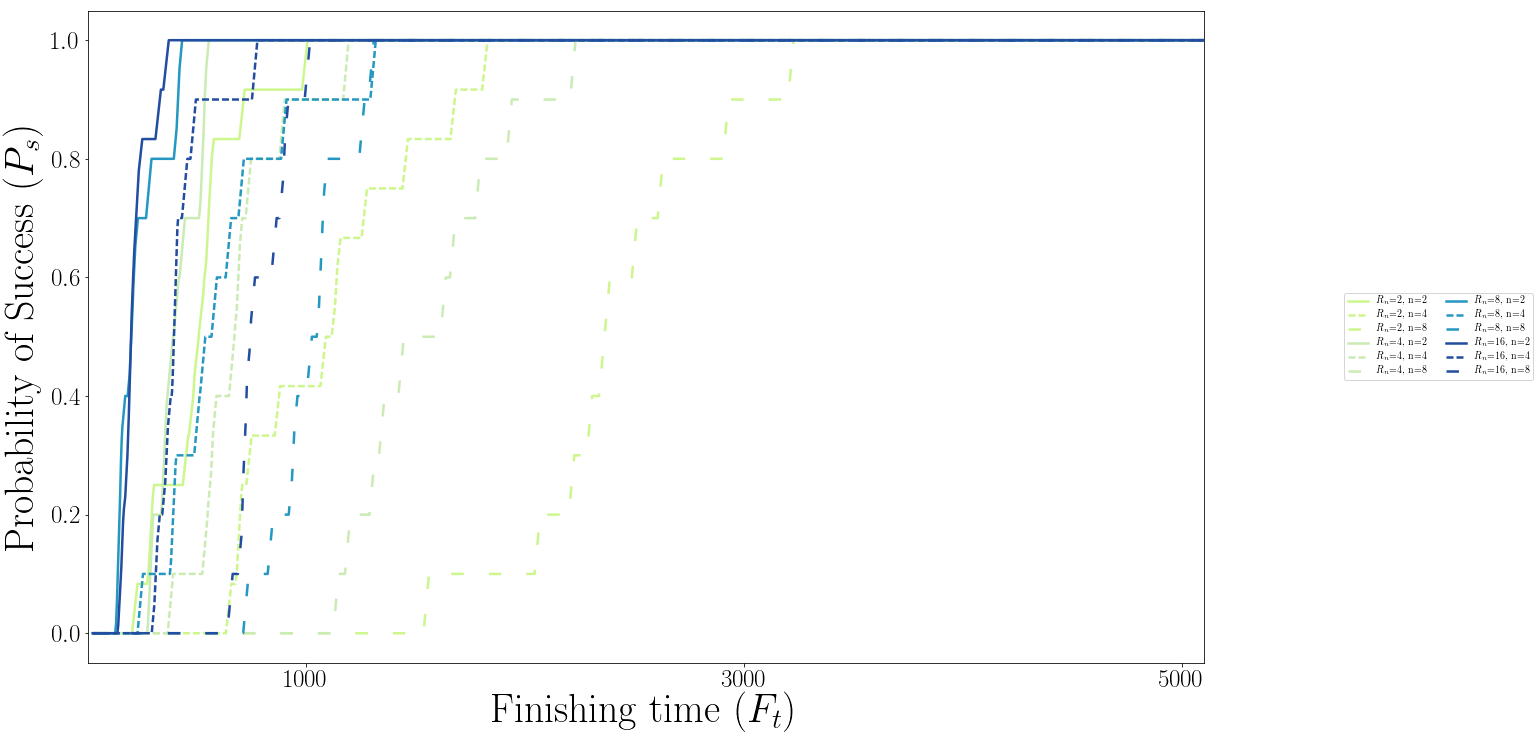

In [27]:
def interpolate(xnew, pair, SUCCESS_PERCENTAGES):
    xnew[0][100] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][100]
    xnew[0][75] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][75]
    xnew[0][50] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][50]
    xnew[0][25] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][25]
    xnew[0][10] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][10]
    xnew[0][0] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][0]
    return xnew

# Success rate calculation
plt.figure(figsize=(20,12))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

pairs = [(i,j) for i in range(len(ROBOT_RANGE)) for j in range(len(TOKEN_RANGE))]

for pair in pairs:
    xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(25).mean()
    #xnew = interpolate(xnew, pair, SUCCESS_PERCENTAGES)
    xnew = xnew.interpolate()
    xnew.dropna(inplace=True)
    #plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], label = "_nolegend")
    plt.plot(xnew, color=color_map[pair[0]], lw=2.5, ls=linestyles[pair[1]], label= str(r'$R_{n}$='+ str(ROBOT_RANGE[pair[0]]) + ', n=' + str(TOKEN_RANGE[pair[1]])))
              
plt.tick_params(labelsize=25)
plt.xticks([i*1000 for i in range(1,51, 2)])
plt.xlim([0,RUN_THRESHOLD])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')

legend_properties = {'size': 10, 'weight': 'bold'}
plt.legend(ncol=2, loc="right", prop=legend_properties,  bbox_to_anchor=(1.30, 0.5))
plt.show()

## Figure Probability of Success for all configuration (Mean lines)

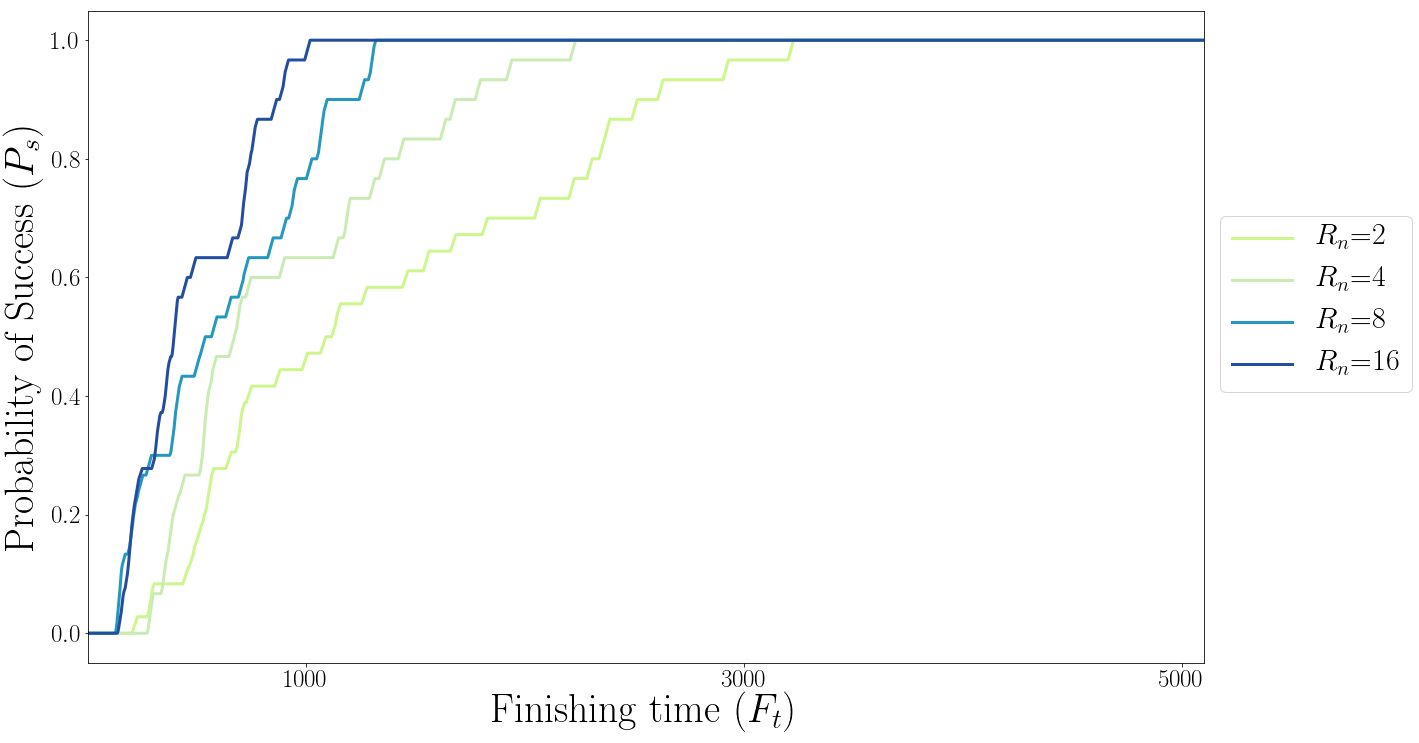

In [28]:
def interpolate(xnew, pair, xnew_mean):
    for i in range(0,120):
        xnew[i] = xnew_mean[i]
    return xnew

plt.figure(figsize=(20,12))

for pair in range(len(ROBOT_RANGE)):
    all_xs = pd.DataFrame(SUCCESS_PERCENTAGES[pair])
    xnew_mean = all_xs.mean(axis=0)
    xnew = xnew_mean.rolling(25).mean()
    xnew = interpolate(xnew, pair, xnew_mean)
    xnew = xnew.interpolate()
    plt.plot(xnew, color=color_map[pair], ls=linestyles[0], lw=3, label = str(r'$R_{n}$='+ str(ROBOT_RANGE[pair])))
    plt.legend(prop={'weight':'bold'})

plt.tick_params(labelsize=25)
plt.xticks([i*1000 for i in range(1,51, 2)])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,RUN_THRESHOLD])
legend_properties = {'size': 30, 'weight': 'bold'}
plt.legend(ncol=1,loc="right", prop=legend_properties, bbox_to_anchor=(1.20, 0.55))
plt.show()

## Probability of Success for all configuration (Mean lines with confidence values)

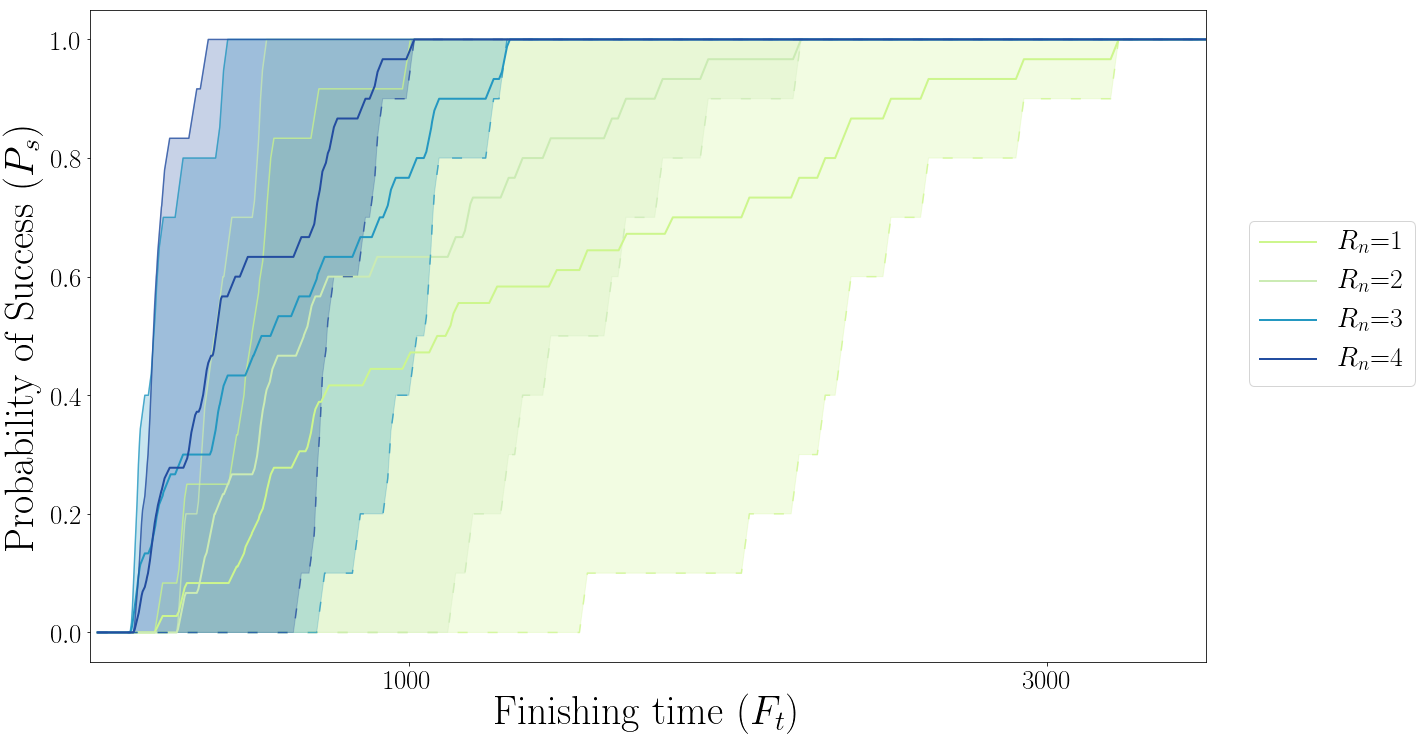

In [29]:
plt.figure(figsize=(20,12))
for pair in range(len(ROBOT_RANGE)):
    # get array for group size 
    all_xs = pd.DataFrame(SUCCESS_PERCENTAGES[pair])
    
    # get borders
    min_ = all_xs.T[0].rolling(25).mean()
    max_ = all_xs.T[2].rolling(25).mean()
    plt.plot(min_, color= color_map[pair],alpha=0.75, ls=linestyles[0], label='_nolegend_')
    plt.plot(max_, color= color_map[pair],alpha=0.75, ls=linestyles[-1], label='_nolegend_')
    plt.fill_between(range(len(min_)),min_,max_,alpha=0.25, color=color_map[pair])
    
    # plot average 
    xnew = all_xs.mean(axis=0)
    xnew = xnew.rolling(25).mean()
    xnew.dropna(inplace=True)
    plt.plot(xnew, color=color_map[pair],label = str(r'$R_{n}$='+ str(pair+1)),lw=2)

legend_properties = {'size': 28, 'weight': 'bold'}
plt.tick_params(labelsize=27)
plt.xticks([i*1000 for i in range(1,51, 2)])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,3500])
plt.legend(ncol=1,loc="right", prop=legend_properties, bbox_to_anchor=(1.20, 0.55))
plt.show()

### Probability of Success for specific configurations (all lines in a conf)

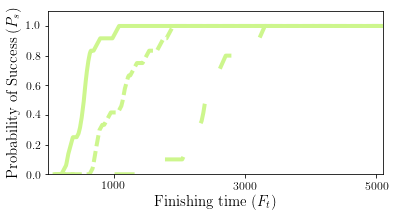

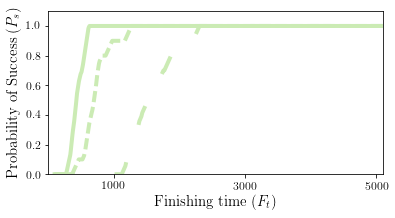

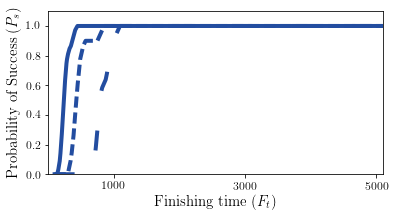

In [33]:
def min_plots(num_bots):
    plt.figure(figsize=(6,3))
    ind = pairs[(num_bots-1)*len(TOKEN_RANGE):(num_bots)*len(TOKEN_RANGE)]
        
    for pair in ind:
        xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(100).mean()
        xnew.dropna(inplace=True)
        plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], lw=4)
        
    plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=15)
    plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=15)
    plt.xticks([i*1000 for i in range(1,51,2)])
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.axis([0, RUN_THRESHOLD, 0, 1.1])
    plt.show()
    
min_plots(1)
min_plots(2)
min_plots(4)

## Figure for finishing time for all configurations (All bars)

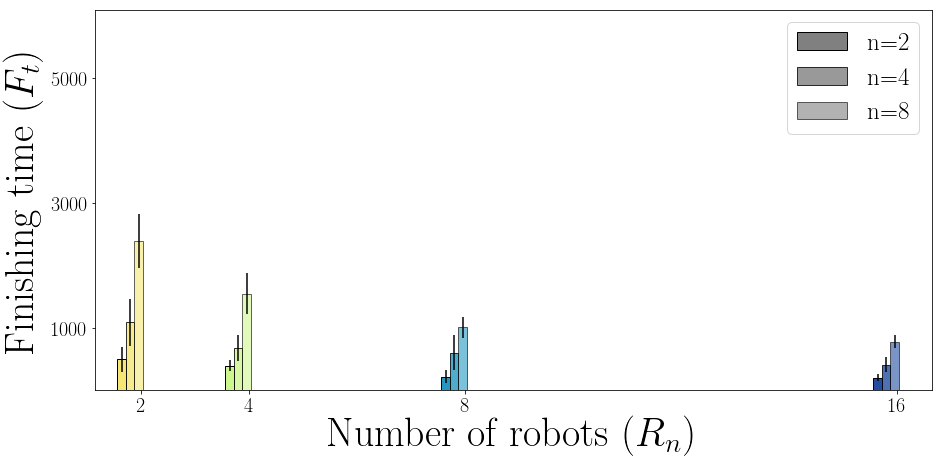

In [38]:
# Finishing Time Calculation
plt.figure(figsize=(15,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bar_width = 0.16
opacity = 0.4

for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    robot_array =[d2[y] for d2 in [d1[:] for d1 in FINISHING_TIMES]]
    rr = np.array(ROBOT_RANGE)
    plt.bar(rr+(bar_width*y), list(map(np.nanmean, zip(robot_array))), bar_width, yerr=list(map(np.nanstd, zip(robot_array))), label='n='+str(NUMBER_OF_TOKENS), color=color_map,  edgecolor='k', lw=1, alpha=1-(y*0.2))
    plt.legend(loc=1, prop={'size': 25})

ax = plt.gca()
leg = ax.get_legend()
for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    leg.legendHandles[y].set_color('grey')
    leg.legendHandles[y].set_edgecolor('black')
    
plt.tick_params(labelsize=20)
plt.xticks(rr+0.36, tuple((i) for i in ROBOT_RANGE))
plt.xlabel('Number of robots' + ' ' + r'$(R_{n})$' , fontsize=40)
plt.yticks([i*1000 for i in range(1,22, 2)])
plt.ylabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.axis([min(ROBOT_RANGE)-0.5, max(ROBOT_RANGE) + 1, 0, RUN_THRESHOLD+1000])
plt.show()

## Figure communication cost for different merkle tree lengths and information diversity

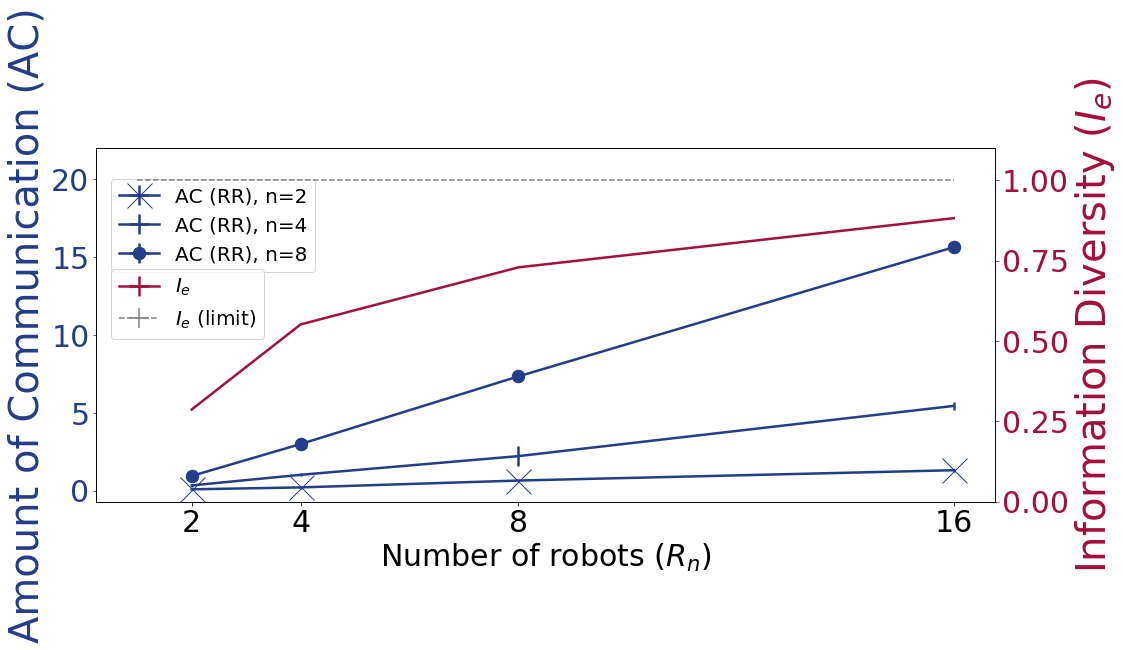

In [45]:
# Communication Cost Vs Information Diversity
fig, ax1 = plt.subplots(figsize=(15,8))
for y, task in enumerate(TOKEN_RANGE):
    
    robot_row = []
    robot_row_std = []
    
    for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
        if NUMBER_OF_ROBOTS == 1:
            robot_row.append(0)
            robot_row_std.append(0)
        else:
            robot_row.append(np.nanmean(COMMUNICATION_COST[x][y]))
            robot_row_std.append(np.nanstd(COMMUNICATION_COST[x][y]))

    if task != 8:
        ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, color='#233D89', markersize=25, marker=markers[y], label=str('AC (RR), n=' + str(TOKEN_RANGE[y])), lw=2.5)
    else:
        ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, color='#233D89', markersize=25, marker=markers[4], label=str('AC (RR), n=' + str(TOKEN_RANGE[y])), lw=2.5)
    
ax1.set_xlabel('Number of robots' + ' ' +  r'$(R_{n})$', fontsize=30)

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Amount of Communication (AC)', color='#233D89', fontsize=40)
ax1.tick_params('y', colors='#233D89')
ax1.set_ylim(top=22.0)
plt.xticks(tuple((i) for i in ROBOT_RANGE))
plt.tick_params(labelsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.78))

ax2 = ax1.twinx()

for y, task in enumerate(TOKEN_RANGE):
    robot_row = []
    robot_row_std = []

    for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):

        if NUMBER_OF_ROBOTS == 1:
            robot_row.append(0)
            robot_row_std.append(0)
        else:    
            robot_row.append(np.nanmean(PRIVACY_COEFFICIENT[x][y]))
            robot_row_std.append(np.nanstd(PRIVACY_COEFFICIENT[x][y]))

ax2.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=0, c='#A4103B', markersize=20, label=str(r'$I_{e}$'), lw=2.5) 
ax2.set_ylabel('Information Diversity' + ' ' + r'$(I_{e})$', color='#A4103B', fontsize=40)
ax2.tick_params('y', colors='#A4103B')

# Limit for Privacy
ax2.errorbar(range(1,17), np.ones(16), xerr=0, yerr=0, c='grey', ls='dashed', markersize=20, label=str(r'$I_{e}$ (limit)')) 

ax2.set_ylim(top=1.1)
fig.tight_layout()
plt.tick_params(labelsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.56))
plt.axis([0.25, 16.75, 0, 1.1])
plt.show()

### Figure information diversity distributions for different task numbers

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2


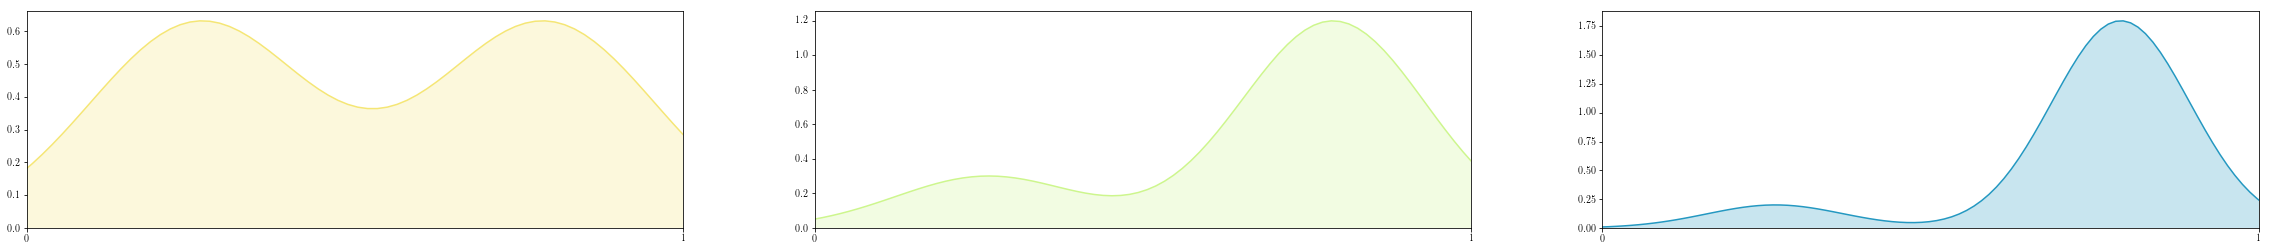

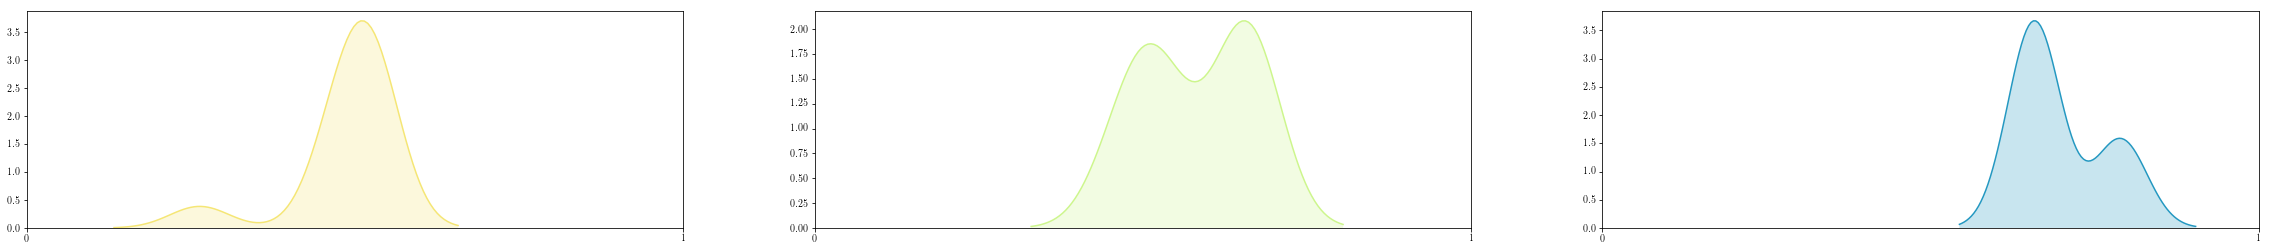

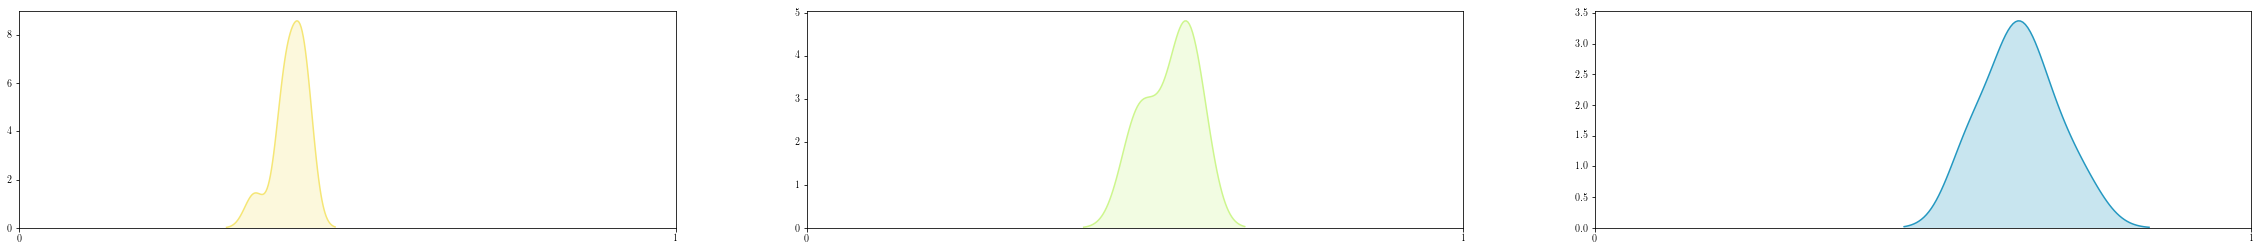

In [41]:
for y, task in enumerate(TOKEN_RANGE):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(40,4), sharex=True)
    
    for x in range(0, 3, 1):
        print x, y
        sns.distplot(PRIVACY_COEFFICIENT[x][y], color=color_map[x], kde_kws={"shade": True}, kde=True, hist=False, ax=ax[x])
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
#         plt.ylim([0,5])
#         plt.axis('off')
#         plt.plot([1.4]*8,[-0.5+(j)*0.5 for j in range(8)], '--',color='grey')
#         plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=200)
#         print('./%d_robots_%d_tasks.png' % ((i+1),1))


2 0
1 0
0 0
2 1
1 1
0 1
2 2
1 2
0 2


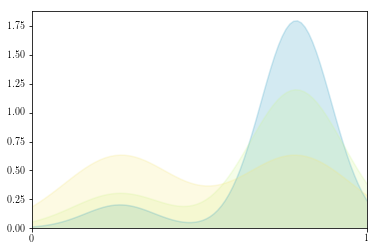

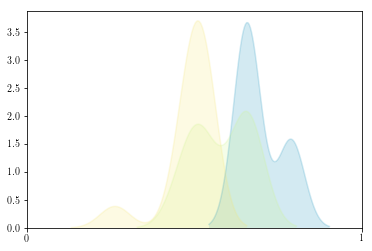

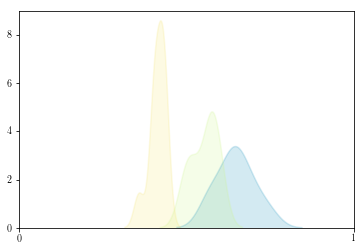

In [42]:
for y, task in enumerate(TOKEN_RANGE):
    fig, ax = plt.subplots()
    for x in reversed([i for i in range(3)]):
        print x,y
        sns.distplot(PRIVACY_COEFFICIENT[x][y], color=color_map[x], kde_kws={"shade": True, 'alpha':0.2}, kde=True, hist=False)
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
    #plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=600)

0 8


IndexError: list index out of range

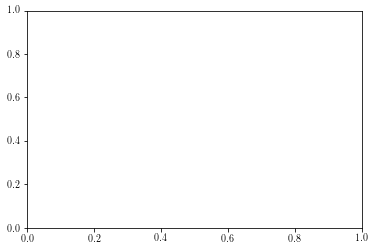

In [47]:
for x in range(0, max(ROBOT_RANGE),3):
    fig, ax = plt.subplots()
    for y in reversed([i for i in TOKEN_RANGE]):
        sns.distplot(PRIVACY_COEFFICIENT[x][y], color=color_map[y], kde_kws={"shade": True, 'alpha':0.7}, kde=True, hist=False)
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
    plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=600)

In [106]:
REALROBOT_FORAGING_COMMUNICATION_GRAPHS = COMMUNICATION_GRAPHS
REALROBOT_FORAGING_COMMUNICATION_COST = COMMUNICATION_COST
REALROBOT_FORAGING_FINISHING_TIMES = FINISHING_TIMES
REALROBOT_FORAGING_PRIVACY_COEEFICIENT = PRIVACY_COEFFICIENT
REALROBOT_FORAGING_SUCCESS_PERCENTAGES = SUCCESS_PERCENTAGES

%store REALROBOT_FORAGING_COMMUNICATION_GRAPHS
%store REALROBOT_FORAGING_COMMUNICATION_COST
%store REALROBOT_FORAGING_PRIVACY_COEEFICIENT
%store REALROBOT_FORAGING_FINISHING_TIMES
%store REALROBOT_FORAGING_SUCCESS_PERCENTAGES

Stored 'REALROBOT_FORAGING_COMMUNICATION_GRAPHS' (list)
Stored 'REALROBOT_FORAGING_COMMUNICATION_COST' (list)
Stored 'REALROBOT_FORAGING_PRIVACY_COEEFICIENT' (list)
Stored 'REALROBOT_FORAGING_FINISHING_TIMES' (list)
Stored 'REALROBOT_FORAGING_SUCCESS_PERCENTAGES' (list)


In [19]:
# with open('REALROBOT_FORAGING_FINISHING_TIMES.pickle', 'rb') as f:
#     FINISHING_TIMES = pickle.load(f)
# with open('REALROBOT_FORAGING_SUCCESS_PERCENTAGES.pickle', 'rb') as f:
#     SUCCESS_PERCENTAGES = pickle.load(f)
# with open('REALROBOT_FORAGING_COMMUNICATION_COST.pickle', 'rb') as f:
#     COMMUNICATION_COST = pickle.load(f)
with open('REALROBOT_FORAGING_COMMUNICATION_GRAPHS.pickle', 'rb') as f:
    COMMUNICATION_GRAPHS = pickle.load(f)

# Write variables to pickle

In [26]:
with open('REALROBOT_FORAGING_FINISHING_TIMES.pickle', 'wb') as f:
    pickle.dump(FINISHING_TIMES, f)
    
with open('REALROBOT_FORAGING_SUCCESS_PERCENTAGES.pickle', 'wb') as f:
    pickle.dump(SUCCESS_PERCENTAGES, f)
    
with open('REALROBOT_FORAGING_COMMUNICATION_COST.pickle', 'wb') as f:
    pickle.dump(COMMUNICATION_COST, f)
            
with open('REALROBOT_FORAGING_COMMUNICATION_GRAPHS.pickle', 'wb') as f:
    pickle.dump(COMMUNICATION_GRAPHS, f)
    
with open('REALROBOT_FORAGING_PRIVACY_COEEFICIENT.pickle', 'wb') as f:
    pickle.dump(PRIVACY_COEFFICIENT, f)    

In [48]:
COMMUNICATION_COST[0][2][0]

1.09375

In [49]:
CommunicationCost(COMMUNICATION_GRAPHS[0][2][0], 8, 32)/1024

1.09375

In [21]:
COMMUNICATION_GRAPHS[0][2][0]

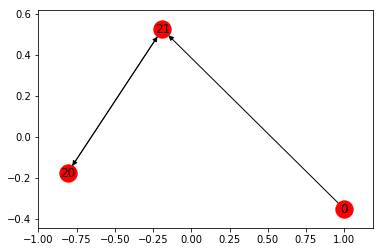

In [42]:
nx.draw_networkx(COMMUNICATION_GRAPHS[0][2][0])

In [72]:
for x in nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight').keys():
    if x[0]!=0:
        print x

AttributeError: 'tuple' object has no attribute 'values'

NameError: name 'typeof' is not defined

In [75]:
sum((value for key, value in x if key[0] != 0), nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight'))

TypeError: 'int' object is not iterable

In [80]:
sum(value for key, value in nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight') if key[0] !=0)

TypeError: 'int' object has no attribute '__getitem__'

In [88]:
nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight')

{(0, 21): 2, (20, 21): 3, (21, 20): 2}

In [97]:
sum(value for key, values in nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight') if origin !=0):

SyntaxError: invalid syntax (<ipython-input-97-9d0865530b04>, line 1)

In [117]:
sum(nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight')[key] for key in nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][2][0],'weight') if key[0] !=0)

5

In [18]:
COMMUNICATION_COST

[[[0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375,
   0.09375],
  [0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.125,
   0.25],
  [0.78125,
   1.09375,
   0.9375,
   0.78125,
   0.9375,
   0.9375,
   1.09375,
   1.09375,
   0.9375,
   0.9375]],
 [[], [], []],
 [[], [], []],
 [[], [], []]]

In [20]:
sum(nx.get_edge_attributes(COMMUNICATION_GRAPHS[-1],'weight')[key] for key in nx.get_edge_attributes(COMMUNICATION_GRAPHS[-1],'weight') if key[0] !=0)

AttributeError: 'list' object has no attribute 'is_multigraph'

In [28]:
FINISHING_TIMES[0][0]

[510]

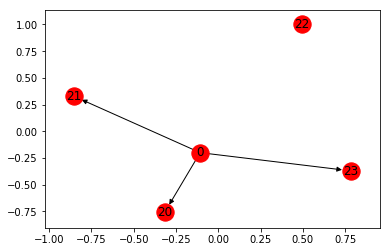

In [33]:
nx.draw_networkx(COMMUNICATION_GRAPHS[0][0][0])

In [35]:
sum(nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][0][0],'weight')[key] for key in nx.get_edge_attributes(COMMUNICATION_GRAPHS[0][0][0],'weight') if key[0] !=0)

0

In [41]:
COMMUNICATION_COST

[[[0,
   0.28125,
   0.1875,
   0.28125,
   0.1875,
   0.1875,
   0.28125,
   0.1875,
   0.28125,
   0.28125]]]